In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example(which='training_data', name='mpsa')
print(f'training N: {len(data_df)}')

# Scale y-values in absurd way
# data_df['y'] = 1000 + 100*data_df['y']

data_df.head()

training N: 16446


,x,y
0,TAAGCTTTA,-3.455265
1,GCAGCCTAT,-3.135494
2,GTGGTAAGG,2.291043
3,TGGGCGCAG,-3.147840
4,GGTGCGGGC,0.547527


In [3]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(x=data_df['x'],
                     y=data_df['y'],
                     alphabet='dna',
                     gpmap_type='pairwise',
                     regression_type='GE',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

# Fit model to data
history = model.fit(learning_rate=.005,
                    epochs=1000,
                    early_stopping=True,
                    early_stopping_patience=20)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has    16446 rows  and       36 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       36

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.282e+02  4.124e+03   1.0e+00  2.5e-01
     1  2.21759e-02  1.158e+02  1.332e+03   9.0e-01  1.5e-01  7.4e+01  1.0e+00
     2  3.11979e-02  1.142e+02  2.344e+02   8.9e-01  1.9e-02  1.1e+02  1.1e+00
     3  3.17511e-02  1.142e+02  1.944e+02   8.9e-01  1.3e-02  1.4e+02  1.1e+00
     4  3.21405e-02  1.141e+02  4.639e+01   8.9e-01  1.5e-03  2.7e+02  1.8e+00
     5  3.30620e-02  1.141e+02  1.069e+01   8.9e-01  3.4e-04  2.7e+02  2.4e+00
     6  3.33971e-02  1.141e+02  1.356e+00   8.9e-01  4.2e-05  2.8e+02  2.4e+00
     7  3.33400e-02  1.141e+02  2.131e-01   8.9e-01  6.5e-06  2.9e+02  2.4e+00
     8  3.33309e-02  1.141e+02  6.560e-02   8.9e-01  2.0e-06  2.9e+02  2.4

In [4]:
model.save('mpsa_ge_pairwise')

Model saved to these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [5]:
# Load model
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [6]:
# Load test data
test_df = mavenn.load_example(which='test_data',name='mpsa')
N_test = len(test_df)
print(f'test data N: {N_test:,}')

# Scale y-values in absurd way
# test_df['y'] = 1000 + 100*test_df['y']

# Subsample indices for easy plotting
ix = np.random.rand(N_test) < 1

# Get x and y
x_test = test_df['x'].values[ix]
y_test = test_df['y'].values[ix]

test data N: 5,483


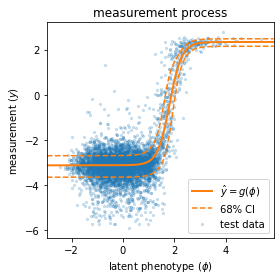

In [7]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 68% CI for each yhat
yqs_grid = model.yhat_to_yq(yhat_grid, q=[0.16, 0.84])

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

Automatically determined gpmap_type=pairwise.


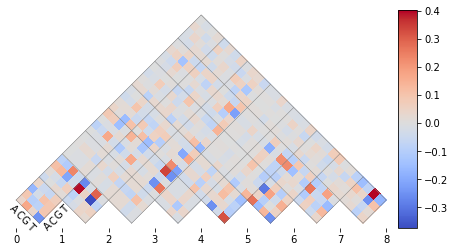

In [8]:
# Plot pairwise parameters
theta_pair_df = model.get_gpmap_parameters(which='pairwise')
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(theta_pair_df, ax=ax);